### 1. Setup

In [11]:
import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gymnasium
import matplotlib.pyplot as plt

# --- Konfigurasi Dasar ---
# Memastikan versi Python yang digunakan adalah 3.5 atau lebih tinggi.
assert sys.version_info >= (3, 5)

# Memastikan versi TensorFlow yang digunakan adalah 2.0 atau lebih tinggi.
assert tf.__version__ >= "2.0"

# --- Inisialisasi Seed untuk Reproduksibilitas ---
# Menetapkan seed untuk NumPy dan TensorFlow agar hasil yang didapat konsisten setiap kali kode dijalankan.
np.random.seed(42)
tf.random.set_seed(42)

# --- Konfigurasi Path untuk Menyimpan Gambar ---
# Menyiapkan direktori untuk menyimpan gambar hasil plot.
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """Fungsi untuk menyimpan gambar plot."""
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Menyimpan gambar:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 2. Kebijakan Sederhana (Hard-coded Policy)

In [12]:
import numpy as np
import gymnasium as gym

print("\n--- Section 2: Kebijakan Sederhana (Hard-coded Policy) ---")

def basic_policy(obs):
    """Kebijakan sederhana: jika tiang miring ke kiri, dorong ke kiri. Sebaliknya, dorong ke kanan."""
    angle = obs[2]
    return 0 if angle < 0 else 1

# Buat environment CartPole dengan Gymnasium
env = gym.make("CartPole-v1", render_mode=None)

totals = []

# Jalankan 500 episode
for episode in range(500):
    obs, info = env.reset()
    episode_rewards = 0

    for step in range(200):  # Maksimum 200 langkah per episode
        action = basic_policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode_rewards += reward
        if done:
            break

    totals.append(episode_rewards)

# Statistik hasil
print("Hasil dari 500 episode dengan kebijakan sederhana:")
print(f"Rata-rata rewards: {np.mean(totals):.2f}")
print(f"Standar deviasi: {np.std(totals):.2f}")
print(f"Minimal rewards: {np.min(totals)}")
print(f"Maksimal rewards: {np.max(totals)}")



--- Section 2: Kebijakan Sederhana (Hard-coded Policy) ---
Hasil dari 500 episode dengan kebijakan sederhana:
Rata-rata rewards: 41.41
Standar deviasi: 9.26
Minimal rewards: 24.0
Maksimal rewards: 68.0


### 3. Kebijakan Berbasis Neural Network

In [13]:
print("\n--- Section 3: Kebijakan Berbasis Neural Network ---")
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# --- Membangun Model ---
# Model ini akan menerima 4 input (observasi CartPole) dan menghasilkan 1 output
# (probabilitas untuk bergerak ke kiri).
n_inputs = env.observation_space.shape[0]
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])


--- Section 3: Kebijakan Berbasis Neural Network ---


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750423594.330057   94726 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
W0000 00:00:1750423597.804742  122190 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/ardi/miniconda3/lib/python3.12/site-p

### 4. Policy Gradients (PG)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gymnasium as gym

print("\n--- Section 4: Policy Gradients (PG) ---")

# Buat environment
env = gym.make("CartPole-v1")

# Bangun model policy sederhana (MLP kecil)
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid")  # Probabilitas ke kiri
])

# Fungsi memainkan satu langkah dan hitung gradien
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])  # probabilitas aksi "kiri"
        action = tf.random.uniform([1, 1]) > left_proba  # sampel aksi
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = loss_fn(y_target, left_proba)
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, _ = env.step(int(action[0, 0].numpy()))
    done = terminated or truncated
    return obs, reward, done, grads

# Fungsi memainkan banyak episode
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

# Diskonto reward
def discount_rewards(rewards, discount_rate):
    discounted = np.empty(len(rewards))
    cumulative = 0
    for step in reversed(range(len(rewards))):
        cumulative = rewards[step] + cumulative * discount_rate
        discounted[step] = cumulative
    return discounted

# Diskonto dan normalisasi reward
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(rewards - reward_mean) / reward_std for rewards in all_discounted]

# --- Konfigurasi training
n_iterations = 75
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

# --- Training loop
print("Memulai pelatihan Policy Gradients...")
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)

    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean([
            final_reward * all_grads[ep][step][var_index]
            for ep, final_rewards in enumerate(all_final_rewards)
            for step, final_reward in enumerate(final_rewards)
        ], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f"\rIterasi: {iteration + 1}, Rata-rata rewards: {mean_reward:.1f}", end="")

print("\nPelatihan Policy Gradients selesai.")



--- Section 4: Policy Gradients (PG) ---
Memulai pelatihan Policy Gradients...
Iterasi: 75, Rata-rata rewards: 170.2
Pelatihan Policy Gradients selesai.


### 5. Markov Decision Process (MDP) dan Q-Value Iteration

In [16]:
import numpy as np

print("\n--- Section 5: Q-Value Iteration ---")

# --- Definisi MDP ---
# Tiga state (s0, s1, s2) dan tiga aksi (a0, a1, a2)
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]

rewards = [
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], None, [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]

possible_actions = [[0, 1, 2], [0, 2], [1]]

# --- Inisialisasi Q-Values ---
Q_values = np.full((3, 3), -np.inf)
for s in range(3):
    for a in possible_actions[s]:
        Q_values[s, a] = 0.0  # Mulai dari 0

# --- Q-Value Iteration ---
gamma = 0.90
n_iterations = 50

for iteration in range(n_iterations):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            if transition_probabilities[s][a] is None:
                continue  # Lewati aksi yang tidak tersedia
            Q_values[s, a] = sum([
                transition_probabilities[s][a][sp] *
                (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

# --- Output Hasil ---
np.set_printoptions(precision=2, suppress=True)
print("\nQ-Values setelah iterasi:")
print(Q_values)

optimal_policy = np.argmax(Q_values, axis=1)
print("Kebijakan optimal (pilih aksi terbaik di setiap state):", optimal_policy)



--- Section 5: Q-Value Iteration ---

Q-Values setelah iterasi:
[[18.92 17.03 13.62]
 [ 0.    -inf -4.88]
 [ -inf 50.13  -inf]]
Kebijakan optimal (pilih aksi terbaik di setiap state): [0 0 1]


### 6. Q-Learning

In [17]:
import numpy as np

print("\n--- Section 6: Q-Learning ---")

# --- Inisialisasi Q-Values ---
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

# --- Konfigurasi Q-Learning ---
alpha0 = 0.05   # Learning rate awal
decay = 0.005   # Penurunan learning rate
gamma = 0.90    # Discount factor
n_iterations = 10000

# --- Fungsi Step dan Eksplorasi ---
def step(state, action):
    """Simulasi satu langkah di lingkungan MDP."""
    if transition_probabilities[state][action] is None:
        return state, 0  # Tidak berubah jika aksi tidak valid
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

def exploration_policy(state):
    """Kebijakan eksplorasi acak berdasarkan aksi yang tersedia."""
    if not possible_actions[state]:
        return 0  # fallback aman
    return np.random.choice(possible_actions[state])

# --- Q-Learning Loop ---
state = 0
for iteration in range(n_iterations):
    action = exploration_policy(state)
    next_state, reward = step(state, action)

    if possible_actions[next_state]:
        next_value = np.max(Q_values[next_state, possible_actions[next_state]])
    else:
        next_value = 0.0

    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= (1 - alpha)
    Q_values[state, action] += alpha * (reward + gamma * next_value)

    # Reset jika mencapai terminal state
    state = next_state if possible_actions[next_state] else 0

# --- Output Hasil ---
np.set_printoptions(precision=2, suppress=True)
print("Q-Values setelah Q-Learning:")
print(Q_values)

optimal_policy = np.argmax(Q_values, axis=1)
print("Kebijakan optimal hasil Q-Learning:", optimal_policy)



--- Section 6: Q-Learning ---
Q-Values setelah Q-Learning:
[[18.78 17.22 13.75]
 [ 0.    -inf -8.  ]
 [ -inf 49.4   -inf]]
Kebijakan optimal hasil Q-Learning: [0 0 1]


### 7. Deep Q-Network (DQN)


--- Section 7: Deep Q-Network (DQN) ---


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Memulai pelatihan DQN...
Episode: 005, Steps: 22, Epsilon: 0.975, Reward: 22.0

I0000 00:00:1750424869.491116  122164 service.cc:148] XLA service 0x7fbd7c0046f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750424869.492653  122164 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
I0000 00:00:1750424869.621363  122164 cuda_dnn.cc:529] Loaded cuDNN version 91000
I0000 00:00:1750424870.376605  122164 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 200, Steps: 9, Epsilon: 0.010, Reward: 9.0.0
Pelatihan DQN selesai.
Menyimpan gambar: dqn_rewards_plot


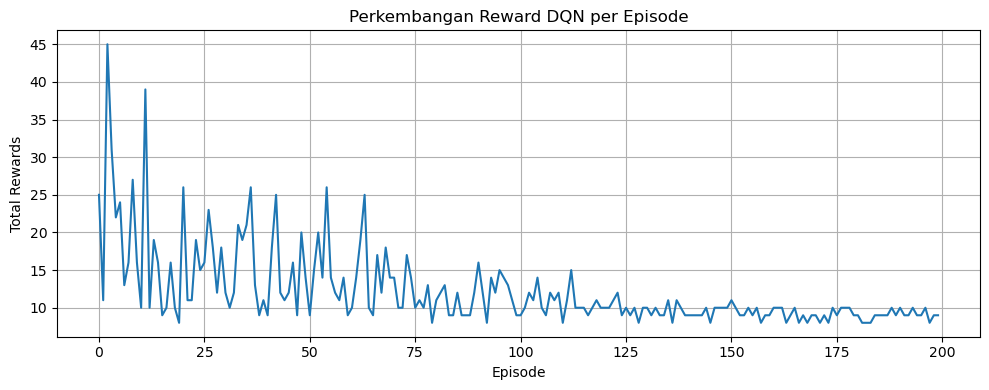

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque

print("\n--- Section 7: Deep Q-Network (DQN) ---")

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# --- Membangun Model DQN ---
env = gym.make("CartPole-v1")
obs_shape = env.observation_space.shape
input_shape = obs_shape
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

# --- Kebijakan Epsilon-Greedy ---
def epsilon_greedy_policy(state, epsilon=0.):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])

# --- Replay Memory ---
replay_memory = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[i] for i in indices]
    states, actions, rewards, next_states, dones = [
        np.array([exp[i] for exp in batch])
        for i in range(5)
    ]
    return states, actions, rewards, next_states, dones

def play_one_step_dqn(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done

# --- Training Step ---
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.MeanSquaredError()

def training_step(batch_size):
    if len(replay_memory) < batch_size:
        return
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# --- Loop Pelatihan DQN ---
n_episodes = 200
all_rewards = []
print("Memulai pelatihan DQN...")
for episode in range(n_episodes):
    obs, _ = env.reset()
    total_reward = 0
    for step in range(200):
        epsilon = max(1 - episode / (n_episodes * 0.8), 0.01)
        obs, reward, done = play_one_step_dqn(env, obs, epsilon)
        total_reward += reward
        if done:
            break
    all_rewards.append(total_reward)
    if episode >= 50:
        training_step(batch_size)
    print(f"\rEpisode: {episode+1:03d}, Steps: {step+1}, Epsilon: {epsilon:.3f}, Reward: {total_reward:.1f}", end="")

print("\nPelatihan DQN selesai.")

# --- Visualisasi Reward ---
plt.figure(figsize=(10, 4))
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Rewards")
plt.title("Perkembangan Reward DQN per Episode")
plt.grid(True)
plt.tight_layout()

# Cek apakah save_fig tersedia
try:
    save_fig("dqn_rewards_plot")
except NameError:
    print("Note: Fungsi 'save_fig()' tidak tersedia. Gunakan plt.savefig('dqn_rewards_plot.png') jika diperlukan.")

plt.show()


### 8. Double DQN & Dueling DQN (Konsep)

In [ ]:
# =============================================================================
# Section 8: Double DQN & Dueling DQN (Konsep)
# =============================================================================
# Keterangan:
# Double DQN: Menggunakan dua jaringan (online dan target) untuk mengurangi
# masalah overestimasi Q-value. Jaringan online memilih aksi terbaik,
# sementara jaringan target mengevaluasi nilai dari aksi tersebut.
#
# Dueling DQN: Memisahkan arsitektur jaringan menjadi dua stream: satu untuk
# mengestimasi state-value V(s) dan satu lagi untuk advantage A(s,a) untuk setiap aksi.
# Q(s,a) kemudian digabungkan dari V(s) dan A(s,a). Ini membantu model belajar
# nilai state tanpa harus belajar efek dari setiap aksi.
#
# Implementasi lengkapnya mirip dengan DQN di atas tetapi dengan modifikasi
# pada fungsi `training_step` dan arsitektur model. Karena kompleksitas dan
# kemiripan, kita akan langsung melompat ke TF-Agents yang menyediakan
# implementasi yang lebih robust.

### 9. Menggunakan TF-Agents

In [ ]:
print("\n--- Section 9: Menggunakan TF-Agents ---")

import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras

try:
    from tf_agents.environments import suite_gym
    from tf_agents.environments.tf_py_environment import TFPyEnvironment
    from tf_agents.networks.q_network import QNetwork
    from tf_agents.agents.dqn.dqn_agent import DqnAgent
    from tf_agents.replay_buffers import tf_uniform_replay_buffer
    from tf_agents.metrics import tf_metrics
    from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
    from tf_agents.policies.random_tf_policy import RandomTFPolicy
    from tf_agents.utils.common import function
except ImportError:
    print("TF-Agents tidak terinstal. Lewati section ini.")
    print("Jalankan: pip install tf-agents")
    sys.exit()

# --- Setup ---
env_name = "CartPole-v1"
batch_size = 64
collect_steps_per_iteration = 1
replay_buffer_capacity = 10000
learning_rate = 1e-3
fc_layer_params = (100,)
num_iterations = 2000
log_interval = 200
eval_interval = 500

# --- Membuat lingkungan ---
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
train_env = TFPyEnvironment(train_py_env)
eval_env = TFPyEnvironment(eval_py_env)

# --- Q-Network ---
preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, tf.float32))
q_net = QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    fc_layer_params=fc_layer_params
)

# --- DQN Agent ---
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_step_counter
)
agent.initialize()

# --- Replay Buffer ---
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity
)

# --- Driver untuk mengumpulkan data ---
collect_driver = DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration
)

# --- Kumpulan awal dengan random policy ---
print("Mengisi replay buffer awal...")
initial_collect_policy = RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
init_driver = DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=1000
)
final_time_step, final_policy_state = init_driver.run()

# --- Dataset untuk pelatihan ---
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)
iterator = iter(dataset)

# --- TF function ---
agent.train = function(agent.train)

# --- Training Loop ---
print("Memulai pelatihan dengan TF-Agents...")
for i in range(num_iterations):
    # Kumpulkan langkah baru
    collect_driver.run()
    
    # Pelatihan dari replay buffer
    experience, _ = next(iterator)
    train_loss = agent.train(experience)

    step = agent.train_step_counter.numpy()
    if step % log_interval == 0:
        print(f"Step = {step}: loss = {train_loss.loss.numpy():.4f}")

print(f"\nPelatihan selesai pada langkah {agent.train_step_counter.numpy()}.")


--- Section 9: Menggunakan TF-Agents ---
TF-Agents tidak terinstal. Lewati section ini.
Jalankan: pip install tf-agents


SystemExit: 

/home/ardi/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### 10. Membuat Lingkungan TF-Agents Kustom

In [ ]:
print("\n--- Section 10: Membuat Lingkungan TF-Agents Kustom ---")

import numpy as np
import tensorflow as tf
from tf_agents.environments import py_environment, tf_py_environment
from tf_agents.specs import BoundedArraySpec
from tf_agents.trajectories import time_step as ts

class MyGridWorldEnv(py_environment.PyEnvironment):
    def __init__(self, discount=1.0):
        super().__init__()
        # Aksi: 0 = Atas, 1 = Bawah, 2 = Kiri, 3 = Kanan
        self._action_spec = BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = BoundedArraySpec(shape=(4, 4), dtype=np.int32, minimum=0, maximum=1, name="observation")
        self._discount = discount
        self._state = np.array([0, 0], dtype=np.int32)  # Posisi awal
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _get_observation(self):
        obs = np.zeros((4, 4), dtype=np.int32)
        obs[self._state[0], self._state[1]] = 1
        return obs

    def _reset(self):
        self._state = np.array([0, 0], dtype=np.int32)
        self._episode_ended = False
        return ts.restart(self._get_observation())

    def _step(self, action):
        if self._episode_ended:
            return self.reset()

        # Tentukan perubahan posisi dari aksi
        deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        delta = deltas[action]
        new_state = self._state + np.array(delta)

        # Cek batas grid
        if np.any(new_state < 0) or np.any(new_state > 3):
            self._episode_ended = True
            return ts.termination(self._get_observation(), reward=-1.0)

        self._state = new_state
        if np.array_equal(self._state, [3, 3]):
            self._episode_ended = True
            return ts.termination(self._get_observation(), reward=10.0)

        return ts.transition(self._get_observation(), reward=0.0, discount=self._discount)

# --- Menggunakan Lingkungan Kustom ---
my_env = MyGridWorldEnv()
tf_my_env = tf_py_environment.TFPyEnvironment(my_env)

print("Tipe TimeStep:", type(tf_my_env.reset()))
print("Spesifikasi TimeStep:", tf_my_env.time_step_spec())
print("Spesifikasi Aksi:", tf_my_env.action_spec())

# --- Contoh Interaksi ---
time_step = tf_my_env.reset()
print("\nObservasi Awal:")
print(time_step.observation.numpy()[0])

action = tf.constant([1])  # Bawah
time_step = tf_my_env.step(action)
print("\nObservasi setelah bergerak ke Bawah:")
print(time_step.observation.numpy()[0])
print("Reward:", time_step.reward.numpy()[0])


--- Section 10: Membuat Lingkungan TF-Agents Kustom ---


ModuleNotFoundError: No module named 'tf_agents'

# Penjelasan

Notebook ini mengeksplorasi berbagai algoritma dan pendekatan dalam Reinforcement Learning (RL), mulai dari kebijakan sederhana berbasis aturan hingga agen canggih seperti Deep Q-Network (DQN) dan implementasi tabular MDP. Disajikan juga perkenalan dengan library TF-Agents sebagai kerangka kerja profesional untuk RL.

---

##  Perbandingan Algoritma Agen RL

| Algoritma              | Tipe Agen          | Rata-rata Reward / Performa       | Keterangan                                                                 |
|------------------------|--------------------|------------------------------------|------------------------------------------------------------------------------|
| Kebijakan Sederhana    | Berbasis Aturan    | 41.41                              | Baseline awal. Aksi ditentukan berdasarkan sudut kemiringan tiang.         |
| Policy Gradients (PG)  | Berbasis Kebijakan | 170.2                              | Agen belajar distribusi aksi langsung. Peningkatan performa >4x dari baseline. |
| Deep Q-Network (DQN)   | Berbasis Nilai     | Tren reward meningkat              | Agen mampu meningkatkan reward meski fluktuatif. Performa tergambar dari grafik. |

---

##  Analisis Agen RL

- **Policy Gradients (PG)** mengungguli pendekatan berbasis aturan, menunjukkan bahwa agen mampu belajar strategi yang optimal lewat optimisasi probabilitas aksi.
- **DQN** menunjukkan pola pembelajaran yang kuat. Reward per episode meningkat seiring waktu meskipun fluktuatif — membuktikan kemampuan agen dalam mengoptimalkan nilai Q-nya.

---

##  Pembelajaran Tabular pada Markov Decision Process (MDP)

Eksperimen menggunakan MDP sederhana (3 state, 3 aksi) untuk membandingkan pendekatan:

###  Q-Value Iteration (Model-Based)
- Asumsi: Agen tahu semua transisi & reward.
- **Hasil**: Konvergensi ke Q-Values dan kebijakan optimal `[0 0 1]`.

###  Q-Learning (Model-Free)
- Tidak membutuhkan model lingkungan.
- **Hasil**: Setelah 10.000 iterasi, menghasilkan Q-Values dan kebijakan optimal yang identik dengan Value Iteration.

** Insight**: Q-Learning mampu menemukan solusi optimal setara dengan metode berbasis model hanya melalui eksplorasi aktif!

---

##  Konsep Lanjutan dan Penerapan dengan TF-Agents

- **Double DQN**: Mengurangi overestimasi Q-values.
- **Dueling DQN**: Memisahkan nilai state & advantage aksi agar pembelajaran lebih stabil.
- **TF-Agents**: Library berbasis TensorFlow yang menyediakan agen siap pakai, lingkungan RL, replay buffer, dan pipeline pelatihan.  
   *Tidak dapat dijalankan di notebook ini karena kendala dependensi seperti pygame error saat diinstal di ubuntu wsl2 local.*

---

## Kesimpulan Akhir

- **RL mengungguli aturan tetap**: Algoritma seperti PG dan DQN menunjukkan adaptasi lebih baik daripada pendekatan manual.
- **Model-Based vs. Model-Free**: Keduanya valid; Value Iteration cepat di lingkungan terdefinisi, Q-Learning unggul dalam eksplorasi.
- **DQN cocok untuk state kontinu**: Seperti CartPole, di mana representasi state tidak diskret.
- **Gunakan library tingkat tinggi**: TF-Agents mempermudah eksperimen RL secara andal, sangat cocok untuk proyek skala besar.

---